<a href="https://colab.research.google.com/github/kmalicekim/NLP_practice_mine/blob/master/10.%20%EB%94%A5%EB%9F%AC%EB%8B%9D%EC%9D%84%20%EC%9D%B4%EC%9A%A9%ED%95%9C%20%EB%AC%B8%EC%84%9C%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 10.3 RNN을 이용한 문서 분류 - NLTK 영화리뷰 감성분석

### 10.3.1 워드 임베딩을 위한 데이터 준비

In [13]:
import nltk
nltk.download('movie_reviews')
from nltk.corpus import movie_reviews

fileids = movie_reviews.fileids()  #movie review data에서 file id를 가져옴

# file id를 이용해 raw test file를 가져옴
reviews = [movie_reviews.raw(fileid) for fileid in fileids] 

# file id를 이용해 라벨로 사용할 카테고리, 즉 긍정/부정 정보를 순서대로 가져옴
categories = [movie_reviews.categories(fileid)[0] for fileid in fileids]

print('Reviews count:', len(reviews))
print('Length of the first review:', len(reviews[0]))
print('Labels:', set(categories))


Reviews count: 2000
Length of the first review: 4043
Labels: {'neg', 'pos'}


[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


In [16]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer 

np.random.seed(7)
tf.random.set_seed(7)

max_words = 10000 # 사용할 단어 수

# 빈도가 높은 10,000개의 단어를 선택하도록 객체 생성
tokenizer = Tokenizer(num_words=max_words, oov_token='UNK') 

# 주어진 말뭉치에 대해 단어 인덱스 사전 구축
tokenizer.fit_on_texts(reviews)  

# 이 사전을 이용해 문서들을 인덱스의 시퀀스로 변환
X = tokenizer.texts_to_sequences(reviews)

print('Lengths of first 10 documents:', [len(doc) for doc in X[:10]])

Lengths of first 10 documents: [710, 240, 486, 479, 733, 671, 550, 584, 702, 776]


In [17]:
print("Index of 'the':", tokenizer.word_index["the"])
print("Index of 'review':", tokenizer.word_index['review'] )
print("Index of out-of-vocabulary words:", tokenizer.word_index['UNK'])

Index of 'the': 2
Index of 'review': 466
Index of out-of-vocabulary words: 1


In [19]:
from tensorflow.keras.preprocessing.sequence import pad_sequences 

# 문서의 단어 수를 제한 
maxlen = 500

# 문서의 단어 수가 500보다 작으면 0을 채우고, 크면 잘라냄
# 잘라낼 때 앞을 자를지, 뒤를 자를지 선택할 수 있음. 앞을 자르고 뒷부분을 쓰고자 하면 'pre' 선택
X = pad_sequences(X, maxlen=maxlen, truncating='pre')

In [20]:
import numpy as np

# label을 0,1의 값으로 변환
label_dict = {'pos':1, 'neg':0}
y = np.array([label_dict[c] for c in categories])
print(set(y))

{0, 1}


In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

print('Train set count:', len(X_train))
print('Test set count:', len(X_test))
print('Test samples:', y_test[:20])

Train set count: 1600
Test set count: 400
Test samples: [0 1 1 0 1 1 0 0 0 0 1 1 0 0 1 0 0 1 1 1]


---

### 10.3.2 RNN이 아닌 일반적인 신경망 모형을 이용한 분류

In [22]:
# keras 모형 생성 및 학습
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Flatten, Dense, Embedding 

# 순차적 모형
model = Sequential([
    Embedding(max_words, 32, input_length=maxlen),  # word embedding layer 생성
    
    # max_words(위에서 10,000이라 지정)은 one-hot encoding을 할 때의 vector 크기가 됨 - 사용된 단어의 수만큼
    # 각 단어는 32크기의 dense vector로 embedding 됨
    # input_length는 한 document의 단어 수로 표현
    ## 이 과정을 거치면 각 document는 (maxlen, 32)의 2차원 행렬이 됨 - 즉 word의 sequence가 됨

    Flatten(),   # 2차원 행렬을 1차원으로 펼침
    Dense(1, activation='sigmoid')   # binary logistic regression을 수행
])

model.summary()  # 모델의 요약정보 출력

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           320000    
                                                                 
 flatten (Flatten)           (None, 16000)             0         
                                                                 
 dense (Dense)               (None, 1)                 16001     
                                                                 
Total params: 336,001
Trainable params: 336,001
Non-trainable params: 0
_________________________________________________________________


In [24]:
# 모형의 optimizer와 loss function 등을 지정
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

# 학습을 수행
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=1,  # 학습 진행 중 학습현황의 출력 여부
                    validation_split=0.2)

Epoch 1/10
40/40 [==============================] - 1s 12ms/step - loss: 0.6913 - acc: 0.5281 - val_loss: 0.6858 - val_acc: 0.5688
Epoch 2/10
40/40 [==============================] - 0s 9ms/step - loss: 0.5859 - acc: 0.9234 - val_loss: 0.6737 - val_acc: 0.6156
Epoch 3/10
40/40 [==============================] - 0s 8ms/step - loss: 0.4473 - acc: 0.9773 - val_loss: 0.6494 - val_acc: 0.6406
Epoch 4/10
40/40 [==============================] - 0s 7ms/step - loss: 0.2894 - acc: 0.9945 - val_loss: 0.6198 - val_acc: 0.6469
Epoch 5/10
40/40 [==============================] - 0s 8ms/step - loss: 0.1608 - acc: 0.9984 - val_loss: 0.5920 - val_acc: 0.6844
Epoch 6/10
40/40 [==============================] - 0s 8ms/step - loss: 0.0786 - acc: 0.9992 - val_loss: 0.5762 - val_acc: 0.6719
Epoch 7/10
40/40 [==============================] - 0s 7ms/step - loss: 0.0348 - acc: 1.0000 - val_loss: 0.5645 - val_acc: 0.6938
Epoch 8/10
40/40 [==============================] - 0s 7ms/step - loss: 0.0140 - acc: 1.0

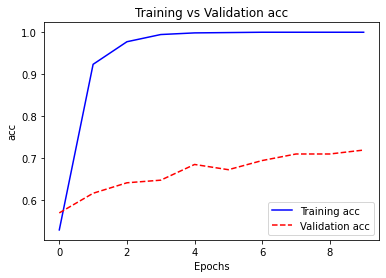

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_results(history, metric):
  plt.plot(history.history[metric], 'b', label='Training '+metric)
  plt.plot(history.history['val_'+metric], 'r--', label='Validation '+metric)
  plt.title('Training vs Validation '+metric)
  plt.xlabel('Epochs')
  plt.ylabel(metric)
  plt.legend() 
  plt.show() 

plot_results(history, 'acc')

In [36]:
# 테스트 셋으로 학습된 모형의 성능을 평가

score = model.evaluate(X_test, y_test) 
print(score) # score[0]은 loss, score[1]은 accuracy

print(f'# Test accuracy:{score[1]:.3f}')   

13/13 [==============================] - 0s 3ms/step - loss: 0.5605 - acc: 0.7225
[0.5605404376983643, 0.7225000262260437]
# Test accuracy:0.723


---

### 10.3.3 문서의 순서정보를 활용하는 RNN 기반 문서분류

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 323,169
Trainable params: 323,169
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
40/40 [==============================] - 5s 99ms/step - loss: 0.6965 - acc: 0.4953 - val_loss: 0.6961 - val_acc: 0.4875
Epoch 2/10
40/40 [==============================]

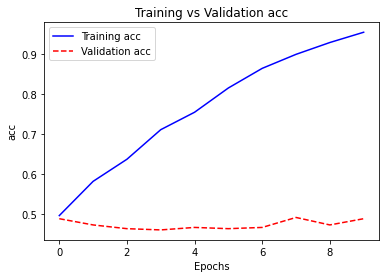

13/13 [==============================] - 1s 22ms/step - loss: 0.6972 - acc: 0.5325
# Test accuracy: 0.533


In [38]:
from tensorflow.keras.layers import SimpleRNN 
from tensorflow.keras.optimizers import Adam 

model = Sequential([ 
    Embedding(max_words, 32),
    SimpleRNN(32),  # 펼쳐서 flat하게 만드는 대신 RNN 모형을 사용, maxlen만큼의 시계열 데이터 
    Dense(32, activation='relu'), # 최종 노드에 대해 은닉층 하나를 추가해 모형의 성능을 높임
    Dense(1, activation='sigmoid')
])

model.summary() 

adam = Adam(learning_rate = 1e-4)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=1,
                    validation_split=0.2) 

plot_results(history, 'acc')

# 테스트 셋으로 학습된 모형의 성능을 평가
score = model.evaluate(X_test, y_test) 
print(f'# Test accuracy: {score[1]:.3f}')



---

## 10.4 LSTM, Bi-LSTM과 GRU를 이용한 성능 개선

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 64)          640000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 714,369
Trainable params: 714,369
Non-trainable params: 0
_________________________________________________________________
Epoch 1/8
40/40 [==============================] - 27s 609ms/step - loss: 0.6928 - acc: 0.5109 - val_loss: 0.6924 

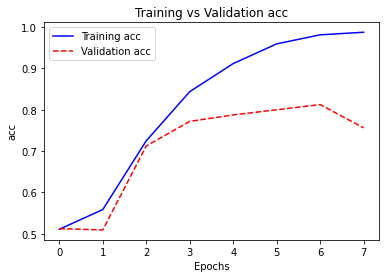

13/13 [==============================] - 2s 98ms/step - loss: 0.7749 - acc: 0.7625
# Test accuracy: 0.762


In [40]:
from tensorflow.keras.layers import LSTM, Bidirectional 

model = Sequential([
    Embedding(max_words, 64),
    Bidirectional(LSTM(64)),  # simple RNN 대신 bidirectional LSTM을 사용
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()

model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc']) 

history = model.fit(X_train, y_train,
                    epochs=8,
                    verbose=1,
                    validation_split=0.2)

plot_results(history, 'acc')


# 테스트 셋으로 학습된 모형의 성능 평가
score = model.evaluate(X_test, y_test) 
print(f'# Test accuracy: {score[1]:.3f}')

In [41]:
y_pred = np.round(model.predict(X_test[:10]))

for pred, y_t in zip(y_pred, y_test[:10]):
  print(f'predicted value: {pred[0]}, true value: {y_t}, so the prediction is {pred[0]==y_t}')

1/1 [==============================] - 1s 914ms/step
predicted value: 0.0, true value: 0, so the prediction is True
predicted value: 1.0, true value: 1, so the prediction is True
predicted value: 1.0, true value: 1, so the prediction is True
predicted value: 1.0, true value: 0, so the prediction is False
predicted value: 1.0, true value: 1, so the prediction is True
predicted value: 1.0, true value: 1, so the prediction is True
predicted value: 0.0, true value: 0, so the prediction is True
predicted value: 1.0, true value: 0, so the prediction is False
predicted value: 0.0, true value: 0, so the prediction is True
predicted value: 0.0, true value: 0, so the prediction is True
